In [3]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 8.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 1.5 MB/s eta 0:00:0000:0100:05


In [4]:
# ==========================
# 0) Imports
# ==========================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix


# ==========================
# 1) Cargar datos
# ==========================
data = pd.read_csv("Iris.csv")  # asegúrate que 'State' exista
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [8]:
target = "Species"   # <<----------------- tu TARGET
assert target in data.columns, f"'{target}' no está en las columnas."

In [9]:
data['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [10]:
X = data.drop(columns=[target])
X

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,5.1,3.5,1.4,0.2
1,2,4.9,3.0,1.4,0.2
2,3,4.7,3.2,1.3,0.2
3,4,4.6,3.1,1.5,0.2
4,5,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3
146,147,6.3,2.5,5.0,1.9
147,148,6.5,3.0,5.2,2.0
148,149,6.2,3.4,5.4,2.3


In [11]:
y = data[target]
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: Species, Length: 150, dtype: object

In [12]:
y_raw = data[target].copy()  # etiquetas en texto: 'Iris-setosa'/'Iris-versicolor'/'Iris-virginica'
y_raw

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: Species, Length: 150, dtype: object

In [14]:
# Codificar y si es categórica para los modelos que lo requieran

# Tomamos la columna Species
y_raw = data["Species"].copy()

# Codificamos a números
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Lo mostramos en el mismo formato que tu ejemplo
y = pd.Series(y, name="Species")  # para que se vea igual que con State
print(y)

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: int64


In [16]:
# Codificación
y_raw = data["Species"].copy()
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Inverso del mapeo (número -> clase)
inv_map = {i: clase for i, clase in enumerate(le.classes_)}
print(inv_map)

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


In [20]:
# Features = todas las columnas menos ID y target
X = data.drop(columns=["Id", target])

RANDOM_STATE = 42

# Split temprano para evitar fuga de info
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ==========================
# 2) Preprocesamiento
# ==========================
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop",
)

# ==========================
# 3) Modelos candidatos
# ==========================
models = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("LDA", LinearDiscriminantAnalysis()),
    ("SGD", SGDClassifier(random_state=RANDOM_STATE)),
    ("KNN", KNeighborsClassifier()),
    ("GNB", GaussianNB()),
    ("DTS", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ("NNM", MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=RANDOM_STATE)),
    ("XGB", XGBClassifier(
        tree_method="hist",
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9
    )),
]

# ==========================
# 4) Evaluación (CV estratificada)
# ==========================
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
}
# 👇 Ignoramos AUC para evitar errores
# if n_classes == 2:
#     scoring["roc_auc"] = "roc_auc"
# elif n_classes > 2:
#     scoring["roc_auc_ovr"] = "roc_auc_ovr"

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
names = []

for name, model in models:
    pipe = ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", model)
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results.append(scores)
    names.append(name)
    line = f"{name:>4} | ACC {scores['test_accuracy'].mean():.3f}±{scores['test_accuracy'].std():.3f} | F1 {scores['test_f1_macro'].mean():.3f}±{scores['test_f1_macro'].std():.3f}"
    print(line)

# ==========================
# 5) Selección por F1-macro
# ==========================
mean_f1 = [r["test_f1_macro"].mean() for r in cv_results]
best_idx = int(np.argmax(mean_f1))
best_name, best_model = models[best_idx]
print(f"\n>>> Mejor por F1_macro: {best_name} (F1={mean_f1[best_idx]:.4f})")

# ==========================
# 6) Entrenar final y evaluar en TEST
# ==========================
final_pipe = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", best_model)
])
final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)

print("\n== Reporte en TEST ==")
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

 LRN | ACC 0.958±0.026 | F1 0.958±0.027
 LDA | ACC 0.975±0.033 | F1 0.975±0.034
 SGD | ACC 0.933±0.033 | F1 0.933±0.033
 KNN | ACC 0.958±0.026 | F1 0.958±0.027
 GNB | ACC 0.950±0.017 | F1 0.950±0.017
 DTS | ACC 0.950±0.017 | F1 0.950±0.017
 RFS | ACC 0.950±0.031 | F1 0.949±0.032
 NNM | ACC 0.950±0.031 | F1 0.950±0.031


/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptro

 XGB | ACC 0.950±0.031 | F1 0.950±0.031

>>> Mejor por F1_macro: LDA (F1=0.9747)

== Reporte en TEST ==
                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000        10
Iris-versicolor     1.0000    1.0000    1.0000        10
 Iris-virginica     1.0000    1.0000    1.0000        10

       accuracy                         1.0000        30
      macro avg     1.0000    1.0000    1.0000        30
   weighted avg     1.0000    1.0000    1.0000        30

Matriz de confusión:
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [23]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# ==========================
# 0) Separar X e y
# ==========================
target = "Species"
y_raw = data[target].copy()

# Codificar target a números
le = LabelEncoder()
y = le.fit_transform(y_raw)
y = y_num  # mantener estilo original

# Features: quitamos "Id" y el target
X = data.drop(columns=["Id", target])

# ==========================
# 1) Identificar columnas categóricas
# ==========================
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# ==========================
# 2) Definir preprocesador
# ==========================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough"
)

# ==========================
# 3) Crear pipeline de modelado
# ==========================
pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        tree_method="hist",
        eval_metric="logloss",
        random_state=42
    ))
])
print("\n  sin balanceo\n")

# ==========================
# 4) Dividir los datos
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ==========================
# 5) Entrenar el modelo
# ==========================
pipeline_rf.fit(X_train, y_train)

# ==========================
# 6) Evaluar en el conjunto de prueba
# ==========================
y_pred = pipeline_rf.predict(X_test)

reporte = classification_report(y_test, y_pred, target_names=le.classes_)
print("Reporte de Clasificación - Dataset Iris")
print(reporte)

print("\nMatriz de Confusión:\n")
print(confusion_matrix(y_test, y_pred))


  sin balanceo

Reporte de Clasificación - Dataset Iris
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      0.93      0.90        15
 Iris-virginica       0.93      0.87      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45


Matriz de Confusión:

[[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]



Reporte de Clasificación (TEST):
                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000        15
Iris-versicolor     0.8235    0.9333    0.8750        15
 Iris-virginica     0.9231    0.8000    0.8571        15

       accuracy                         0.9111        45
      macro avg     0.9155    0.9111    0.9107        45
   weighted avg     0.9155    0.9111    0.9107        45


Matriz de Confusión (TEST):
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


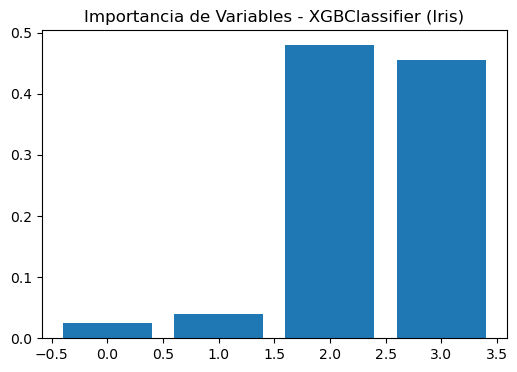

In [24]:
# =========================================
# Multiclase: XGBClassifier (Species)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix
)

from xgboost import XGBClassifier

# ==========================
# 0) Separar X e y
# ==========================
target = "Species"
y_raw = data[target].copy()

# Codificar target a números
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Features
X = data.drop(columns=["Id", target])

# ==========================
# 1) Identificar columnas
# ==========================
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# ==========================
# 2) Definir preprocesador
# ==========================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough"
)

# ==========================
# 3) Train/Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42
)

# ==========================
# 4) Modelo XGBClassifier
# ==========================
xgb = XGBClassifier(
    tree_method="hist",
    eval_metric="mlogloss",   # multiclase
    random_state=42,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0
)

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", xgb)
])

# ==========================
# 5) Entrenamiento
# ==========================
pipeline_xgb.fit(X_train, y_train)

# ==========================
# 6) Evaluación
# ==========================
y_pred = pipeline_xgb.predict(X_test)

print("\nReporte de Clasificación (TEST):")
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))

print("\nMatriz de Confusión (TEST):")
print(confusion_matrix(y_test, y_pred))

# ==========================
# 7) (Opcional) Visualizar importancia de variables
# ==========================
plt.figure(figsize=(6,4))
xgb.feature_importances_  # importancia de features numéricas
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.title("Importancia de Variables - XGBClassifier (Iris)")
plt.show()


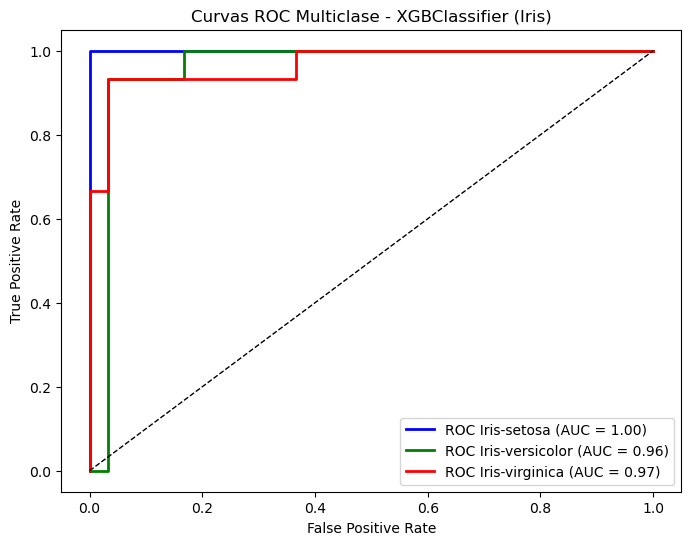

In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# ==========================
# 7) Curvas ROC Multiclase
# ==========================
n_classes = len(le.classes_)

# Binarizar etiquetas (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_score = pipeline_xgb.predict_proba(X_test)

# Calcular ROC y AUC para cada clase
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular ROC micro y macro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas
plt.figure(figsize=(8,6))
colors = ["blue", "green", "red"]

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"ROC {le.classes_[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC Multiclase - XGBClassifier (Iris)")
plt.legend(loc="lower right")
plt.show()


In [35]:
# ==========================
# 7) (Opcional) Guardar modelo y LabelEncoder
# ==========================
from joblib import dump

# Guardar el pipeline completo (preprocesador + modelo)
dump(pipeline_xgb, "modelo_iris_xgb.joblib")

# Guardar el LabelEncoder (para decodificar clases al predecir)
dump(le, "label_encoder_iris.joblib")

print("✅ Modelo y LabelEncoder guardados correctamente.")
